<a href="https://colab.research.google.com/github/nv-hiep/ImageDenoising/blob/main/GalaxyImageDenoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Denoising Colored Image using Autoencoders**

Training dataset: Galaxy Zoo

## **Connect to google drive**

In [ ]:
import os
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/google_drive')

Drive already mounted at /content/google_drive; to attempt to forcibly remount, call drive.mount("/content/google_drive", force_remount=True).


In [ ]:
from __future__ import absolute_import, unicode_literals, print_function
import matplotlib.pyplot as plt 
import cv2 
import numpy as np 
from sklearn.model_selection import train_test_split
import tensorflow as tf 

# Load data - GalaxyZoo

In [ ]:
DATA_DIR = "/content/google_drive/My Drive/data/galaxy_data"
DATA_PATH = os.path.join("/content/google_drive/My Drive/data/galaxy_data/training/", "trainset")
TEST_PATH = os.path.join("/content/google_drive/My Drive/data/galaxy_data/validation/", "testset")
sample_images_20 = os.listdir(DATA_PATH + '/galaxy')[:2000]
print(sample_images_20[:5])

['732197.jpg', '733199.jpg', '734284.jpg', '742022.jpg', '742232.jpg']


In [ ]:
len(sample_images_20)

2000

Load a picture

/content/google_drive/My Drive/data/galaxy_data/training/trainset/galaxy/732197.jpg
(200, 200, 3)


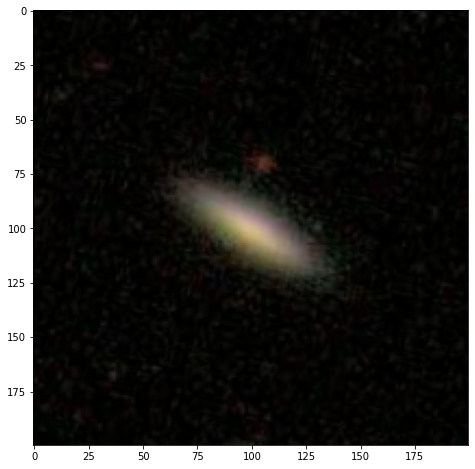

In [ ]:
path = os.path.join(DATA_PATH, 'galaxy', '732197.jpg')
print(path)
src = cv2.imread(path)
src = cv2.resize(src, (200, 200))
print(src.shape)
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(8,8))
plt.imshow(src)
plt.show()

# Add noise

Add GaussianBlur

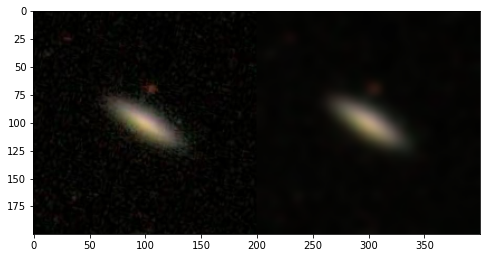

In [ ]:
# using imread()
path = os.path.join(DATA_PATH, 'galaxy', '732197.jpg')
img = cv2.imread(path)
img = cv2.resize(img, (200, 200))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

dst = cv2.GaussianBlur(img,(15,15),cv2.BORDER_DEFAULT) 

plt.figure(figsize=(8,8))
plt.imshow(np.hstack((img, dst)))
# plt.imshow(dst)
plt.show()

Add noise

In [ ]:
# adds the gaussian noise based on the mean and the standard deviation 
def add_gaussian_noise(data):
  mean = (1, 1, 1)
  std = (2, 2, 2)
  row, col, channel = data.shape
  noise = np.random.normal(mean, std, (row, col, channel)).astype('uint8')
  return data + noise

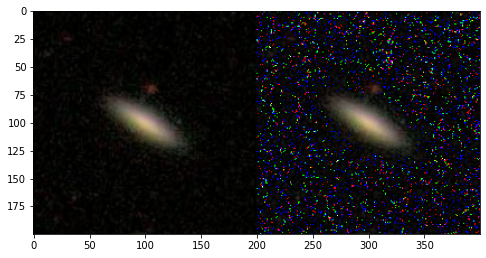

In [ ]:
# using imread()
path = os.path.join(DATA_PATH, 'galaxy', '732197.jpg')
img = cv2.imread(path)
img = cv2.resize(img, (200, 200))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

dst = add_gaussian_noise(img)

plt.figure(figsize=(8,8))
plt.imshow(np.hstack((img, dst)))
# plt.imshow(dst)
plt.show()

Add salt and pepper noise 

In [ ]:
# adds salt and pepper noise 
def add_salt_pepper_noise(data, p=0.05):
  rows, columns, channels = data.shape
  output = np.zeros(data.shape, np.uint8)
  for i in range(rows):
    for j in range(columns):
      r = np.random.random()
      if r < p/2:
        output[i][j] = [0, 0, 0]
      elif r > p/2 and r <= p:
        output[i][j] = [255, 255, 255]
      else:
        output[i][j] = data[i][j]
  return output

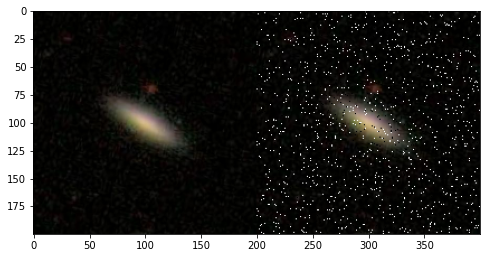

In [ ]:
# using imread()
path = os.path.join(DATA_PATH, 'galaxy', '732197.jpg')
img = cv2.imread(path)
img = cv2.resize(img, (200, 200))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

dst = add_salt_pepper_noise(img)

plt.figure(figsize=(8,8))
plt.imshow(np.hstack((img, dst)))
# plt.imshow(dst)
plt.show()

Add noise to dataset

In [ ]:
len(sample_images_20)

2000

In [ ]:
del sample_images_20

In [ ]:
data = []
for img in sample_images_20:
  path = os.path.join(DATA_PATH, 'galaxy', img)
  x = cv2.imread(path)
  x = cv2.resize(x, (200, 200))
  x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

  data.append(x)

  # dst = add_gaussian_noise(img)
data = np.array(data)

In [ ]:
with open( os.path.join(DATA_DIR, 'galaxy_4000.pkl'), 'wb') as fp:
  pickle.dump(data, fp)

In [ ]:
file = open(os.path.join(DATA_DIR, 'galaxy_4000.pkl'),'rb')
data = pickle.load(file)
file.close()

In [ ]:
data.shape

(2000, 200, 200, 3)

In [ ]:
def add_gaussian_to_dataset(data):
  count = 0
  end = len(data)
  output_data = []
  while count < end:
    output_data.append(add_gaussian_noise(data[count]))
    count+=1
  return np.array(output_data)

In [ ]:
def add_gaussian_blur_to_dataset(data):
  count = 0 
  end = len(data)
  output_data = []
  while count < end:
    output_data.append(add_gaussian_blur(data[count]))
    count+=1
  return np.array(output_data)

I am using a smaller training set to reserve memory, use more pictures if you have a lot of RAM. 

In [ ]:
train_data = data[:1700]
test_data = data[1700:2000]
# uncomment this for denoiser 
# gaussian_train_data = add_gaussian_to_dataset(train_data)
# gaussian_test_data = add_gaussian_to_dataset(test_data)

In [ ]:
del data

In [ ]:
noisy_train_data = add_gaussian_to_dataset(train_data)
noisy_test_data = add_gaussian_to_dataset(test_data)

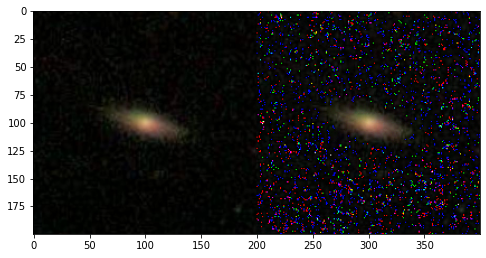

In [ ]:
# Check the images
plt.figure(figsize=(8,8))
plt.imshow(np.hstack((train_data[1], noisy_train_data[1])))
plt.show()

# Train the model

Scale the data between 0 and 1

In [ ]:
train_data = train_data / 255.
test_data = test_data / 255.

In [ ]:
noisy_train_data = noisy_train_data / 255.
noisy_test_data = noisy_test_data / 255.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Activation

In [ ]:
from tensorflow.keras import backend as K

Construct the autoencoder model

In [ ]:
def build(width, height, depth, filters=(32, 64), latentDim=16):
  # initialize the input shape to be "channels last" along with
  # the channels dimension itself
  # channels dimension itself
  inputShape = (height, width, depth)
  chanDim = -1

  # define the input to the encoder
  inputs = Input(shape=inputShape)
  x = inputs
  # loop over the number of filters
  for f in filters:
    # apply a CONV => RELU => BN operation
    x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(axis=chanDim)(x)
  
  # flatten the network and then construct our latent vector
  volumeSize = K.int_shape(x)
  x = Flatten()(x)
  latent = Dense(latentDim)(x)
  # build the encoder model
  encoder = Model(inputs, latent, name="encoder")

  # start building the decoder model which will accept the
  # output of the encoder as its inputs
  latentInputs = Input(shape=(latentDim,))
  x = Dense(np.prod(volumeSize[1:]))(latentInputs)
  x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
  # loop over our number of filters again, but this time in
  # reverse order
  for f in filters[::-1]:
    # apply a CONV_TRANSPOSE => RELU => BN operation
    x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(axis=chanDim)(x)
    # apply a single CONV_TRANSPOSE layer used to recover the
    # original depth of the image
    x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
    outputs = Activation("sigmoid")(x)
  
  # build the decoder model
  decoder = Model(latentInputs, outputs, name="decoder")
  # our autoencoder is the encoder + decoder
  autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
  # return a 3-tuple of the encoder, decoder, and autoencoder
  return (encoder, decoder, autoencoder)

In [ ]:
# construct our convolutional autoencoder
(encoder, decoder, autoencoder) = build(200, 200, 3)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
encoder (Functional)         (None, 16)                2579792   
_________________________________________________________________
decoder (Functional)         (None, 200, 200, 3)       2760806   
Total params: 5,340,598
Trainable params: 5,340,214
Non-trainable params: 384
_________________________________________________________________


In [ ]:
opt = Adam(learning_rate=1.e-3)
autoencoder.compile(loss="mse", optimizer=opt)

In [ ]:
# auto_encoder = create_model()
# auto_encoder.summary()

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=3)
history = autoencoder.fit(noisy_train_data, train_data,
                           epochs=50,
                           batch_size=32,
                           callbacks=[early_stop]
                          )

Epoch 1/50
54/54 [==============================] - 87s 2s/step - loss: 0.1337
Epoch 2/50
54/54 [==============================] - 85s 2s/step - loss: 0.0218
Epoch 3/50
54/54 [==============================] - 85s 2s/step - loss: 0.0119
Epoch 4/50
54/54 [==============================] - 85s 2s/step - loss: 0.0089
Epoch 5/50
54/54 [==============================] - 85s 2s/step - loss: 0.0072
Epoch 6/50
54/54 [==============================] - 85s 2s/step - loss: 0.0060
Epoch 7/50
54/54 [==============================] - 85s 2s/step - loss: 0.0053
Epoch 8/50
54/54 [==============================] - 85s 2s/step - loss: 0.0047
Epoch 9/50
54/54 [==============================] - 85s 2s/step - loss: 0.0039
Epoch 10/50
54/54 [==============================] - 86s 2s/step - loss: 0.0034
Epoch 11/50
54/54 [==============================] - 85s 2s/step - loss: 0.0030
Epoch 12/50
54/54 [==============================] - 85s 2s/step - loss: 0.0028
Epoch 13/50
54/54 [==============================

Plot the training loss

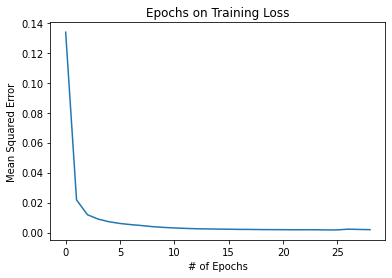

In [ ]:
plt.plot(history.epoch, history.history['loss'])
plt.title('Epochs on Training Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
from google.colab import files
autoencoder.save('denoise.model')
files.download('denoise.model')

INFO:tensorflow:Assets written to: denoise.model/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluate the model on the test set

In [ ]:
result = autoencoder.predict(noisy_test_data)
autoencoder.evaluate(test_data, noisy_test_data)

10/10 [==============================] - 5s 509ms/step - loss: 0.0334


0.03343004360795021

# Compare the images

In [ ]:
TEST_PATH = os.path.join("/content/google_drive/My Drive/data/galaxy_data/validation/", "testset")
sample_images_10 = os.listdir(TEST_PATH + '/galaxies')[:10]
print(sample_images_10[:5])

['100434.jpg', '101246.jpg', '101296.jpg', '101627.jpg', '101754.jpg']


## Image 1

/content/google_drive/My Drive/data/galaxy_data/training/trainset/galaxy/141162.jpg
(200, 200, 3)


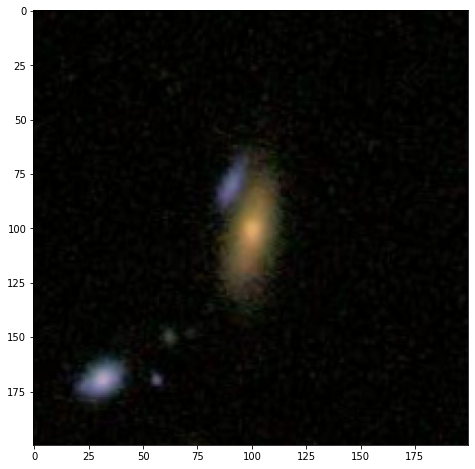

In [ ]:
# original image
path = os.path.join(DATA_PATH, 'galaxy', sample_images_20[1710])
print(path)
src = cv2.imread(path)
src = cv2.resize(src, (200, 200))
print(src.shape)
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(5,5))
plt.imshow(src)
plt.show()

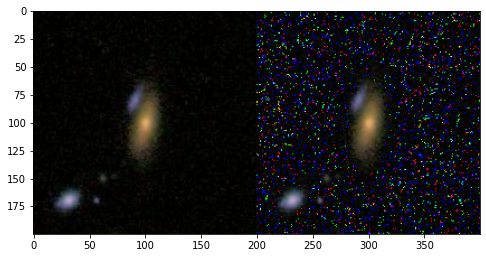

In [ ]:
# Check the images (original image and noisy image)
plt.figure(figsize=(8,8))
plt.imshow(np.hstack((test_data[10], noisy_test_data[10])))
plt.show()

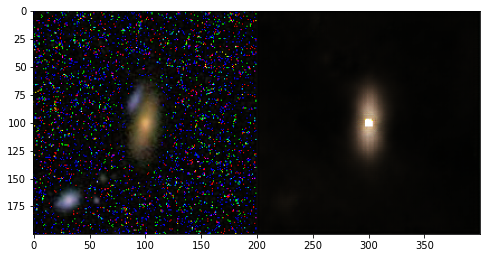

In [ ]:
# Check the images (Noisy image, constructed image)
plt.figure(figsize=(8,8))
plt.imshow(np.hstack((noisy_test_data[10], result[10])))
plt.show()

## Image 2

/content/google_drive/My Drive/data/galaxy_data/training/trainset/galaxy/323454.jpg
(200, 200, 3)


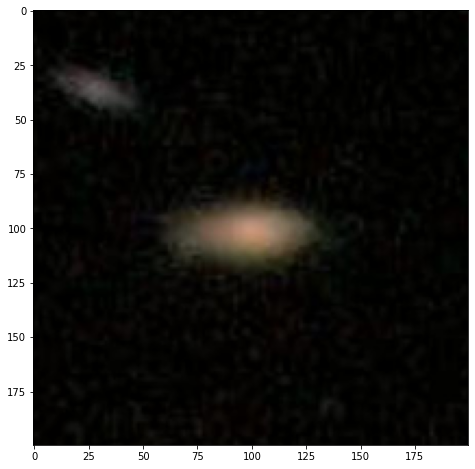

In [ ]:
# Original image
path = os.path.join(DATA_PATH, 'galaxy', sample_images_20[1800])
print(path)
src = cv2.imread(path)
src = cv2.resize(src, (200, 200))
print(src.shape)
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(8,8))
plt.imshow(src)
plt.show()

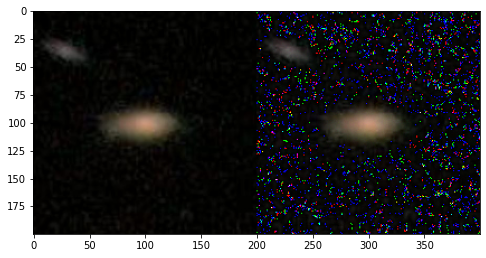

In [ ]:
# Check the images (original image and noisy image)
plt.figure(figsize=(8,8))
plt.imshow(np.hstack((test_data[100], noisy_test_data[100])))
plt.show()

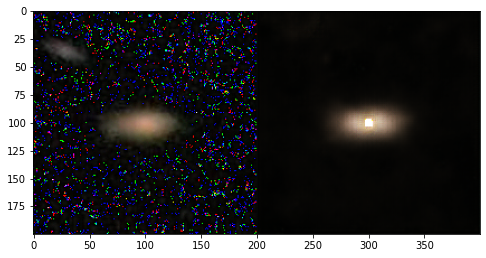

In [ ]:
# Check the images (Noisy image and constructed image)
plt.figure(figsize=(8,8))
plt.imshow(np.hstack((noisy_test_data[100], result[100])))
plt.show()

## Image 3

/content/google_drive/My Drive/data/galaxy_data/training/trainset/galaxy/516851.jpg
(200, 200, 3)


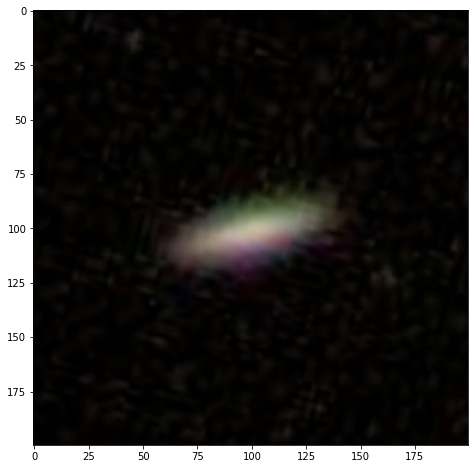

In [ ]:
# Original image
path = os.path.join(DATA_PATH, 'galaxy', sample_images_20[1900])
print(path)
src = cv2.imread(path)
src = cv2.resize(src, (200, 200))
print(src.shape)
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(8,8))
plt.imshow(src)
plt.show()

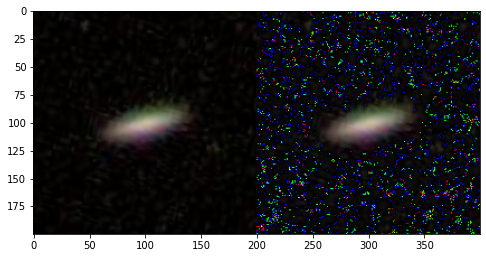

In [ ]:
# Check the images (original image and noisy image)
plt.figure(figsize=(8,8))
plt.imshow(np.hstack((test_data[200], noisy_test_data[200])))
plt.show()

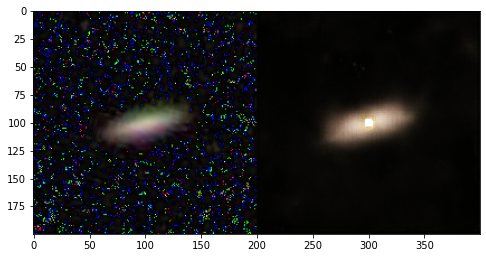

In [ ]:
# Check the images (Noisy image and constructed image)
plt.figure(figsize=(8,8))
plt.imshow(np.hstack((noisy_test_data[200], result[200])))
plt.show()

## Image 4

/content/google_drive/My Drive/data/galaxy_data/training/trainset/galaxy/617894.jpg
(200, 200, 3)


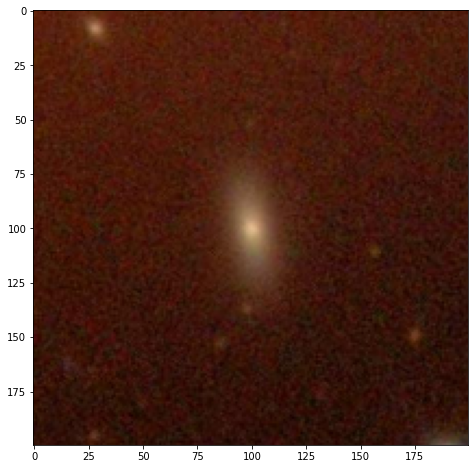

In [ ]:
# Original image
path = os.path.join(DATA_PATH, 'galaxy', sample_images_20[1950])
print(path)
src = cv2.imread(path)
src = cv2.resize(src, (200, 200))
print(src.shape)
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(8,8))
plt.imshow(src)
plt.show()

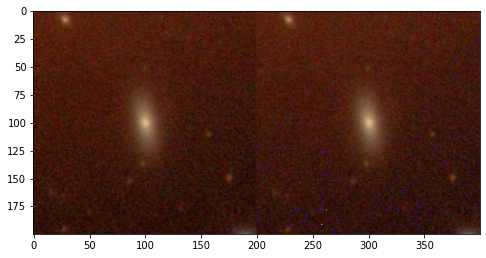

In [ ]:
# Check the images (original image, noisy image)
plt.figure(figsize=(8,8))
plt.imshow(np.hstack((test_data[250], noisy_test_data[250])))
plt.show()

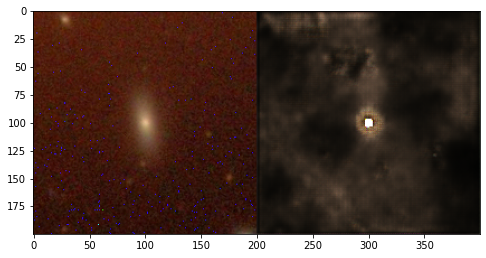

In [ ]:
# Check the images (Noisy image, constructed image)
plt.figure(figsize=(8,8))
plt.imshow(np.hstack((noisy_test_data[250], result[250])))
plt.show()

## Image 5

/content/google_drive/My Drive/data/galaxy_data/training/trainset/galaxy/217289.jpg
(200, 200, 3)


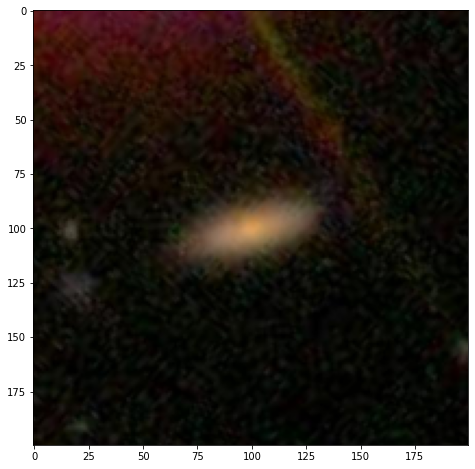

In [ ]:
# Original image
path = os.path.join(DATA_PATH, 'galaxy', sample_images_20[1750])
print(path)
src = cv2.imread(path)
src = cv2.resize(src, (200, 200))
print(src.shape)
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(8,8))
plt.imshow(src)
plt.show()

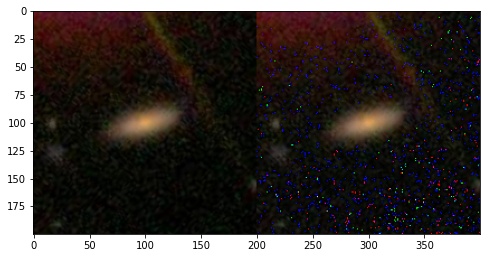

In [ ]:
# Check the images (original image, noisy image)
plt.figure(figsize=(8,8))
plt.imshow(np.hstack((test_data[50], noisy_test_data[50])))
plt.show()

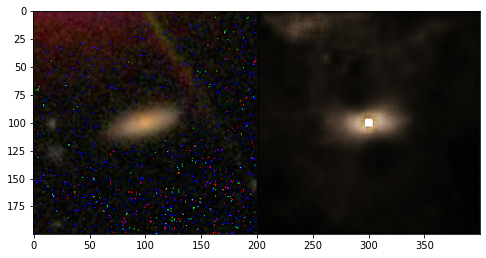

In [ ]:
# Check the images (Noisy image, constructed image)
plt.figure(figsize=(8,8))
plt.imshow(np.hstack((noisy_test_data[50], result[50])))
plt.show()